In [1]:
import collections
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import pandas as pd
import random as rn
from keras import backend as K
rs = 27
np.random.seed(rs)
rn.seed(rs)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(rs)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  Normalizer
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, auc, roc_curve, average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import warnings
#from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam
from keras import initializers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('./Ped1_Train.csv')
df_test = pd.read_csv('./Ped1_Test.csv')
df_train = df_train.rename(columns = {'Abnormal':'label'})
df_test = df_test.rename(columns = {'Abnormal':'label'})

In [3]:
# For ped 1, update speed column. 
def adj_speed_x(df_train):
    df_velo_x = df_train['Velo_x']
    df_velo_y = df_train['Velo_y']
    df_speed = ((df_velo_x/1.5)**2 + (df_velo_y)**2)**0.5
    df_train['Speed'] = df_speed
    return df_train
df_train = adj_speed_x(df_train)
df_test = adj_speed_x(df_test)

In [4]:
def adj_speed_y(df_train):
    #Adjust Speed (Speed/center_y*100)
    df_center_y = df_train['Center_y']
    df_speed = df_train['Speed']
    df_speed_adj = 1000*df_speed.div(df_center_y**1.15)
    df_train['Speed'] = df_speed_adj
    return df_train
df_train = adj_speed_y(df_train)
df_test = adj_speed_y(df_test)

In [5]:
def get_video_frames(df):
    test_video_id = df.iloc[:,2].values
    test_frame_id = df.iloc[:,3].values
    #get video frame number
    video_frames = collections.defaultdict(int)
    for i in range(len(test_video_id)):
        if test_frame_id[i] > video_frames[test_video_id[i]]:
            video_frames[test_video_id[i]] = test_frame_id[i]
    return video_frames
test_video_frames = get_video_frames(df_test)

In [6]:
df_test.head()

,Dataset,type,videoId,Frame_id,Person_id,Center_x,Center_y,Velo_x,Velo_y,Speed,...,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,label
0,Ped1,Test,Test001,1,1,181.958,78.429,0.438,-0.313,2.836963,...,0,0,0,0,0,0,0,0,0,0
1,Ped1,Test,Test001,1,2,191.524,78.915,0.491,-0.006,2.154417,...,0,0,0,0,0,0,0,0,0,0
2,Ped1,Test,Test001,1,3,124.710,69.996,0.322,-0.403,3.449127,...,0,0,0,0,0,0,0,0,0,0
3,Ped1,Test,Test001,1,4,127.254,89.585,-0.330,0.784,4.631317,...,0,0,0,0,0,0,0,0,0,0
4,Ped1,Test,Test001,1,5,41.153,112.372,-0.679,-0.081,2.015420,...,0,0,0,0,0,0,0,0,0,0


# video ground truth

| video ID | abnormal person ID                  | start end frame | video ID | abnormal person ID | start end frame |
|----------|-------------------------------------|-----------------|----------|--------------------|-----------------|
| 1        | 47                                  | 60:152          | 19       |     car            | 64:138          |
| 2        | 23, 28                              | 50:175          | 20       |     car            | 45:175          |
| 3        | 43                                  | 91:200          | 21       |    16(wheel chair) | 31:200          |
| 4        | 32                                  | 31:168          | 22       |      11            | 16:107          |
| 5        | 33,74,85                            | 5:90, 140:200   | 23       |     wheel chair    | 8:165           |
| 6        | 36, 86, 112, 115                    | 1:100, 110:200  | 24       |      car           | 50:171          |
| 7        | 8, 20, 23, 55                       | 1:175           | 25       |       9            | 40:135          |
| 8        | 6                                   | 1:94            | 26       |      22            | 77:144          |
| 9        | 14 (step on grass)                  | 1:48            | 27       |       car          | 10:122          |
| 10       | 4                                   | 1:140           | 28       |       17           | 105:200         |
| 11       | 2 (change direction, step on grass) | 70:165          | 29       |      5, 12         | 1:15, 45:133    |
| 12       | 43                                  | 130:200         | 30       |       21           | 175:200         |
| 13       | 13(push cart), 16                   | 1:156           | 31       |6,13,{16,19}(grass) | 1:180           |
| 14       | 8, 12, 29,truck                     | 1:200           | 32       |      6, 14         | 1:52,65:115     |
| 15       | 18                                  | 138:200         | 33       |      16,21,29      | 5:165           |
| 16       | 24                                  | 123:200         | 34       |       14           | 1:121           |
| 17       | 2                                   | 1:47            | 35       |       40           | 86:200          |
| 18       | 45                                  | 54:120          | 36       |       car          | 15:108          |

In [7]:
#slice with whole video
test_video_id = df_test.iloc[:,2].values
uni_vid = sorted(list(set(test_video_id)))
c_thres = 2.2
stay_time = 0.16
for video in uni_vid[:36]:
#     video = 'Test003'
    df_v = df_test.loc[df_test['videoId'] == video]
    speed_mean = sum(df_v['Speed'])/len(df_v['Speed'])
    print("="*80)
    print("In video {}, the overall mean speed is {}".format(video, speed_mean))

    person_list = list(set(df_v['Person_id']))
    p_speed = []
    p_number = []
    for pid in person_list:
        p_speed.append(df_v.loc[df_v['Person_id'] == pid]['Speed'].mean())
        p_number.append(len(df_v.loc[df_v['Person_id'] == pid])/test_video_frames[video])

    for i in range(len(p_speed)):
        if p_speed[i] >= c_thres*speed_mean and .8 >= p_number[i] >= stay_time:
            print("In video {} person {} speed is {} and p_number is {}".format(video, person_list[i], p_speed[i], p_number[i]))
        
    
# plt.plot(person_list, p_speed)
# plt.scatter(person_list, p_number)
# plt.show()

In video Test001, the overall mean speed is 3.228708862675729
In video Test001 person 47 speed is 8.888111518241338 and p_number is 0.29
In video Test002, the overall mean speed is 3.6865588848880857
In video Test002 person 23 speed is 8.246901992267388 and p_number is 0.48
In video Test003, the overall mean speed is 3.2760879266554848
In video Test003 person 43 speed is 8.192795568014034 and p_number is 0.455
In video Test004, the overall mean speed is 3.595704961800369
In video Test005, the overall mean speed is 3.35233388984364
In video Test005 person 33 speed is 10.196774676505896 and p_number is 0.24
In video Test005 person 85 speed is 9.804070496324535 and p_number is 0.255
In video Test006, the overall mean speed is 3.6675528644578432
In video Test006 person 86 speed is 9.063181356104822 and p_number is 0.38
In video Test007, the overall mean speed is 3.410240272429835
In video Test008, the overall mean speed is 3.293079643234097
In video Test009, the overall mean speed is 3.241

# Add New Feature Here

In [8]:
import pickle
with open('./bg_seg_Ped1_1.pickle','rb') as f:  # Python 3: open(..., 'rb')
    bg_ped = pickle.load(f)
bg_dic = {24: "on_tree", 25: "on_pave", 26: "on_grass"}
bgxmax, bgymax = 157, 237

In [9]:
bg_ped

array([[24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24],
       ...,
       [25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25]], dtype=int64)

In [10]:
aa = np.round(np.array(25.1))
if aa in bg_dic:
    print(bg_dic[aa], type(bg_dic[aa]))

on_pave <class 'str'>


In [11]:
import tqdm
def getlstsq_residual(df_x, df_y):
    X = np.array(df_x)
    y = np.array(df_y)
    X = np.vstack([X,np.ones(len(y))]).T
    res = np.linalg.lstsq(X, y,  rcond=None)[1]
    return res[0] if res.size > 0 else 0

def insert_featrue(df_test, c_thres = 1.93, stay_time = 0.16):
    test_video_frames = get_video_frames(df_test)
    #Update feature name
    col = list(df_test.columns.values[:4])+["y_min","y_max","y_median","y_std","x_min","x_max","x_median","x_std",
                                            "Speed_min","Speed_max","Speed_median","Speed_std","Speed_mean",
                                            "Velo_resi","Coord_resi","tracked_occur",
                                            "on_tree","on_pave","on_grass"] +list(df_test.columns.values[11:])
    df_out = pd.DataFrame(columns = col)
    #slice with whole video
    df_test = df_test.rename(columns = {'Abnormal':'label'})
    test_video_id = df_test.iloc[:,2].values
    test_frame_id = df_test.iloc[:,3].values
    uni_vid = sorted(list(set(test_video_id)))
    
    for video in tqdm.tqdm_notebook(uni_vid):
        df_v = df_test.loc[df_test['videoId'] == video]
        speed_mean = sum(df_v['Speed'])/len(df_v['Speed'])
#         print("="*80)
        #print("In video {}, the overall mean speed is {}".format(video, speed_mean))

        person_list = list(set(df_v['Person_id']))
        p_speed = []
        p_number = []
        for pid in person_list:
            p_speed.append(df_v.loc[df_v['Person_id'] == pid]['Speed'].mean())
            p_number.append(len(df_v.loc[df_v['Person_id'] == pid])/test_video_frames[video])
        person_tracked = []
        for i in range(len(p_speed)):
            if p_speed[i] >= c_thres*speed_mean and .8 >= p_number[i] >= stay_time:
                #print("In video {} person {} speed is {} and p_number is {}".format(video, person_list[i], p_speed[i], p_number[i]))
                person_tracked.append(person_list[i])
        #print(person_tracked)
        for f_id in range(1,test_frame_id[-1]+1):
            df_f = df_test.loc[(df_test['videoId'] == video) & (df_test['Frame_id'] == f_id)]
            # feature tracked_occur
            person_frame = set(df_f['Person_id']) 
            tracked_occur = 0
            for p_t in person_tracked:
                if p_t in person_frame:
                    tracked_occur = 1
                    break
            df1 = df_f.iloc[:1, :4]
            # feature background:
            df1["on_tree"], df1["on_pave"], df1["on_grass"] = 0, 0, 0
            xl, yl, ycl = np.clip(df_f["Center_x"],0,bgxmax), np.clip(df_f["foot_y"],0,bgymax), np.clip(df_f["Center_y"],0,bgymax)
            for x, y, yc in zip(xl, yl, ycl):
                bgid = bg_ped[int(np.round(x))][int(np.round(y))]
                bgid1 = bg_ped[int(np.round(x))][int(np.round(yc))]
                if bgid != bgid1:
                    continue
                if bgid in bg_dic:
                    df1[bg_dic[bgid]]+=1
            #add features here
            df1["y_min"] = df_f["Center_y"].min()
            df1["y_max"] = df_f["Center_y"].max()
            df1["y_median"] = df_f["Center_y"].median()
            y_std = df_f["Center_y"].std()
            df1["y_std"] = y_std if not np.isnan(y_std) else 0
            df1["x_min"] = df_f["Center_x"].min()
            df1["x_max"] = df_f["Center_x"].max()
            df1["x_median"] = df_f["Center_x"].median()
            x_std = df_f["Center_x"].std()
            df1["x_std"] = x_std if not np.isnan(x_std) else 0
            df1["Speed_min"] = df_f['Speed'].min()
            df1["Speed_max"] = df_f['Speed'].max()
            df1["Speed_median"] = df_f['Speed'].median()
            df1["Speed_std"] = df_f["Speed"].std() if not np.isnan(df_f["Speed"].std()) else 0
            df1["Speed_mean"] = df_f['Speed'].mean()
            df1["Velo_resi"] = getlstsq_residual(df_f['Velo_x'], df_f['Velo_y'])
            df1["Coord_resi"] = getlstsq_residual(df_f['Center_x'], df_f['Center_y'])*0.001
            df1["tracked_occur"] = tracked_occur
            result = pd.concat([df1, df_f.iloc[:1, 11:]], axis=1, sort=False)
            df_out = df_out.append(result)
    return df_out

In [12]:
df_test_new = insert_featrue(df_test)
df_test_new

C:\Users\44266\.conda\envs\VAD\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

In [74]:
video,f_id = "Test001",1
df_f = df_test.loc[(df_test['videoId'] == video) & (df_test['Frame_id'] == f_id)]
df_f.iloc[:1, :4]

,Dataset,type,videoId,Frame_id
0,Ped1,Test,Test001,1


## Show different parameter result

In [ ]:
for c_thres in list(np.arange(3,1,-0.20)):
    df_test_new = insert_featrue(df_test, c_thres = c_thres)
    df_train_new = insert_featrue(df_train, c_thres = c_thres)
    print(c_thres, sum(df_test_new['tracked_occur']), sum(df_train_new['tracked_occur']))


|c_thres|df_test|df_train|
|---|---|---|
|3.0|225|99|
|2.8|357|99|
|2.5999999999999996|572|215|
|2.3999999999999995|978|251|
|2.1999999999999993|1580|385|
|1.9999999999999991|2039|819|
|1.799999999999999 |2409|1204|
|1.5999999999999988|3340|1966|
|1.3999999999999986|4857|2889|
|1.1999999999999984|5880|4763|




In [12]:
df_test_new = insert_featrue(df_test, c_thres = 2.2)
df_train_new = insert_featrue(df_train, c_thres = 2.2)

c:\users\44266\.conda\envs\vad\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


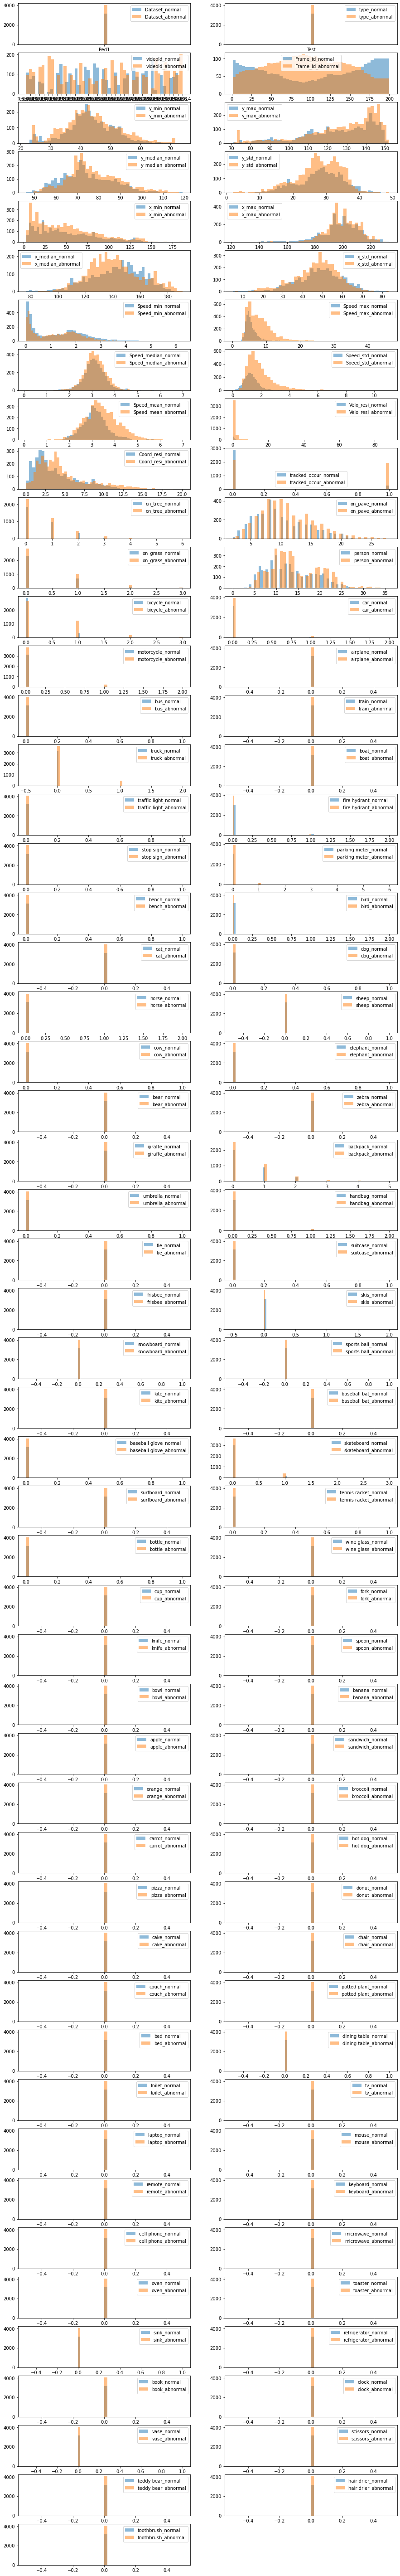

In [82]:
def plot_df(df_test):
    df_test_normal = df_test[df_test['label']==0]
    df_test_abnormal = df_test[df_test['label']==1]
    i = 1
    plt.figure(figsize=(15, 120))
    for col in df_test.columns[:-1]:
        #print(col)
        plt.subplot(60, 2, i)
        f = plt.hist(df_test_normal[col], label=col+'_normal', bins=50, alpha=0.5)
        f = plt.hist(df_test_abnormal[col], label=col+'_abnormal',bins=50, alpha=0.5)
        plt.legend()
        i += 1

plot_df(df_test_new)



|c_thres|df_test|df_train|
|---|---|---|
|3.0|225|99|
|2.8|357|99|
|2.5999999999999996|572|215|
|2.3999999999999995|978|251|
|2.1999999999999993|1580|385|
|1.9999999999999991|2039|819|
|1.799999999999999 |2409|1204|
|1.5999999999999988|3340|1966|
|1.3999999999999986|4857|2889|
|1.1999999999999984|5880|4763|




In [83]:
sum(df_test_new.isnull().values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [197]:
# Read new data
df_train_new = pd.read_csv('PedOutput_Merge/Ped1_Train_add_feature.csv')
df_test_new = pd.read_csv('PedOutput_Merge/Ped1_Test_add_feature.csv')
df_train_new = df_train_new.iloc[:,1:]
df_test_new = df_test_new.iloc[:,1:]

In [56]:
# Drop most of training data
remove_n = 0
drop_indices = np.random.choice(df_train_new.index, remove_n, replace=False)
df_subset = df_train_new.drop(drop_indices)
df_subset.head()

,Dataset,type,videoId,Frame_id,y_min,y_max,y_median,y_std,x_min,x_max,...,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,label
0,Ped1,Train,Train001,1,38.344,121.044,87.671,26.154050,14.784,197.263,...,0,0,0,0,0,0,0,0,0,0
1,Ped1,Train,Train001,2,38.344,121.044,87.671,26.154050,14.784,197.263,...,0,0,0,0,0,0,0,0,0,0
2,Ped1,Train,Train001,3,38.344,121.044,87.671,26.154050,14.784,197.263,...,0,0,0,0,0,0,0,0,0,0
3,Ped1,Train,Train001,4,34.407,122.018,85.410,28.289765,35.550,197.382,...,0,0,0,0,0,0,0,0,0,0
4,Ped1,Train,Train001,5,38.981,124.286,88.974,24.912435,34.000,196.200,...,0,0,0,0,0,0,0,0,0,0


In [199]:
df_test_new.columns.values[19:27]

array(['tracked_occur', 'on_tree', 'on_pave', 'on_grass', 'person',
       'bicycle', 'car', 'motorcycle'], dtype=object)

In [200]:
pd.concat([df_test_new.iloc[:,19:27], df_test_new.iloc[:,-1:]], axis=1, sort=False)

,tracked_occur,on_tree,on_pave,on_grass,person,bicycle,car,motorcycle,label
0,0,1,16,0,18,0,0,0,0
1,0,1,16,0,17,0,0,0,0
2,0,1,16,0,17,0,0,0,0
3,0,1,16,0,16,0,0,0,0
4,0,1,17,0,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7195,0,2,9,0,15,1,0,0,0
7196,0,4,9,0,17,1,0,0,0
7197,0,4,9,0,18,1,0,0,0
7198,0,3,9,0,17,1,0,0,0


In [79]:
X_train = df_subset.iloc[:,4:] 
X_test = df_test_new.iloc[:,4:]
# X_train = pd.concat([df_subset.iloc[:,23], df_subset.iloc[:,-1:]], axis=1, sort=False)
# X_test = pd.concat([df_test_new.iloc[:,23], df_test_new.iloc[:,-1:]], axis=1, sort=False)

X_train = X_train.drop(['label'], axis=1)


print('test: ', X_test['label'].value_counts())
y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)


X_train = X_train.values
X_test = X_test.values


#add noise matrix for denoising AE
noise_factor = 0.01
scale = 1.0

print('noise_factor = %f' % noise_factor)
print('noise_scale = %f' % scale)



from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_de = X_train + noise_factor * np.random.normal(loc=0.000, scale=scale, size=X_train.shape)
X_test_de = X_test + noise_factor* np.random.normal(loc=0.000, scale=scale, size=X_test.shape)

# export feature normalization file
joblib.dump(scaler, 'Scaler.pkl')


input_dim = X_train_de.shape[1]
input_layer = Input(shape=(input_dim,))

my_init = initializers.glorot_uniform(seed=rs)
# my_init = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=rs)
# my_init = initializers.Zeros()
# my_init = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=0)

# augmented denoising AE
encoder = Dense(50, activation="sigmoid",
                kernel_initializer=my_init,
               )(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dense(30, activation="sigmoid",
                kernel_initializer=my_init,
                )(encoder)
encoder = BatchNormalization()(encoder)
decoder = Dense(50, activation="sigmoid",
                kernel_initializer=my_init,
               )(encoder)
decoder = BatchNormalization()(decoder)

decoder = Dense(input_dim, activation='linear', 
                kernel_initializer=my_init,
               )(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)

epoch = 25
batch_size = 120
# autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


autoencoder.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath="deamodel2.h5", verbose=0, save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# use one-class data to train
history = autoencoder.fit(X_train_de, X_train,
                          epochs=epoch,
                          batch_size=batch_size,
                          shuffle=False,
                          validation_data=(X_test_de, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history
autoencoder.summary()

print('denoisingAE')


pred = autoencoder.predict(X_test_de)

#  recontrcution error MSE

mse = np.sum(np.power(X_test - pred, 2), axis=1)

test:  1    4045
0    3155
Name: label, dtype: int64
noise_factor = 0.010000
noise_scale = 1.000000
Train on 6800 samples, validate on 7200 samples
Epoch 1/25
6800/6800 [==============================] - 2s 296us/step - loss: 0.2418 - val_loss: 0.1025
Epoch 2/25
6800/6800 [==============================] - 0s 47us/step - loss: 0.0392 - val_loss: 0.0553
Epoch 3/25
6800/6800 [==============================] - 0s 42us/step - loss: 0.0185 - val_loss: 0.0300
Epoch 4/25
6800/6800 [==============================] - 0s 42us/step - loss: 0.0112 - val_loss: 0.0185
Epoch 5/25
6800/6800 [==============================] - 0s 45us/step - loss: 0.0084 - val_loss: 0.0136
Epoch 6/25
6800/6800 [==============================] - 0s 42us/step - loss: 0.0069 - val_loss: 0.0111
Epoch 7/25
6800/6800 [==============================] - 0s 42us/step - loss: 0.0061 - val_loss: 0.0098
Epoch 8/25
6800/6800 [==============================] - 0s 47us/step - loss: 0.0056 - val_loss: 0.0090
Epoch 9/25
6800/6800 [=====

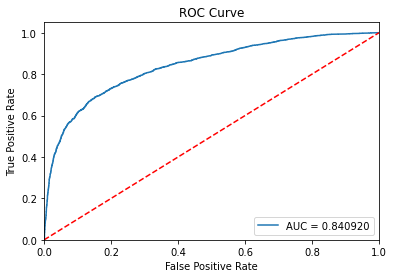

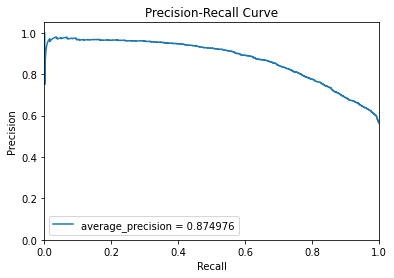

AUC:  0.8409198419523625
AP:  0.8749758442430813
The EER is 0.238221740309271 and the thresh is 0.4094171672251018


In [80]:
y_test = y_test.astype(int)

autoencoder_reconstruction = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

fpr, tpr, roc_threshold = roc_curve(autoencoder_reconstruction.true_class,
                                 autoencoder_reconstruction.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = %f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1.0], [0, 1.0], 'r--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


precision, recall, pr_threshold = precision_recall_curve(autoencoder_reconstruction.true_class,
                                                  autoencoder_reconstruction.reconstruction_error)

average_precision = average_precision_score(autoencoder_reconstruction.true_class,
                                            autoencoder_reconstruction.reconstruction_error)

plt.title('Precision-Recall Curve')
plt.plot(recall, precision, label='average_precision = %f' % average_precision)
plt.legend(loc='lower left')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print('AUC: ', roc_auc)
print('AP: ', average_precision)

from scipy.optimize import brentq
from scipy.interpolate import interp1d

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, roc_threshold)(eer)
print("The EER is {} and the thresh is {}".format(eer, thresh))

# Error Analysis

In [31]:
thres = 0.015
mse_norm = mse/max(mse)
col = ["videoId","Frame_id","mse","pred","label"]
df_err = pd.DataFrame(columns = col)
r_label = df_test_new.loc[:, "label"]
df_err["label"] = r_label
df_err[["videoId", "Frame_id"]] = df_test_new.loc[:, ["videoId", "Frame_id"]]
df_err["mse"] = mse_norm
df_err["pred"] = (mse_norm > thres).astype(int)
print("For thres {} the pos pred is {} and real pos is {}".format(thres, sum(df_err["pred"]),sum(df_err["label"])))

#slice video
test_video_id = df_err.iloc[:,0].values
uni_vid = sorted(list(set(test_video_id)))
col1 = ["videoId", "tpr", "fpr"]
df_tp = pd.DataFrame(columns = col1)
for video in uni_vid[:36]:
    df_v = df_err.loc[df_err['videoId'] == video]
    TP = sum((df_v['label'] == 1) & (df_v['pred'] == 1))
    P, N = sum(df_v['label'] == 1),  sum(df_v['label'] == 0)
    FP = sum((df_v['label'] == 0) & (df_v['pred'] == 1))
    #print("The tpr of {} is {:8.4f}, fpr is {:8.4f}".format(video, TP/P if not P == 0 else 0, FP/N if not N == 0 else 0))
    df_r = pd.DataFrame([[video, TP/P if not P == 0 else 0, FP/N if not N == 0 else 0]], columns = col1)
    df_tp = df_tp.append(df_r,ignore_index=True)
df_tp.sort_values(by = ['tpr'])


For thres 0.015 the pos pred is 4264 and real pos is 4045


,videoId,tpr,fpr
20,Test021,0.170588,0.233333
10,Test011,0.406250,0.500000
22,Test023,0.424051,0.285714
3,Test004,0.485507,0.370968
17,Test018,0.492537,0.270677
8,Test009,0.541667,0.697368
9,Test010,0.557143,0.150000
12,Test013,0.596154,0.090909
28,Test029,0.690476,0.181034
24,Test025,0.812500,0.134615


In [305]:
df_tp

,videoId,tpr,fpr


In [242]:
df_test_new.columns

Index(['Dataset', 'type', 'videoId', 'Frame_id', 'y_min', 'y_max', 'y_median',
       'y_std', 'x_min', 'x_max',
       ...
       'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
       'teddy bear', 'hair drier', 'toothbrush', 'label'],
      dtype='object', length=104)

In [176]:
df_train_new.to_csv("PedOutput_Merge/Ped1_Train_add_feature.csv")
df_test_new.to_csv("PedOutput_Merge/Ped1_Test_add_feature.csv")

In [49]:
df_test_new.head()

,Dataset,type,videoId,Frame_id,y_min,y_max,y_median,y_std,x_min,x_max,...,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,label
0,Ped1,Test,Test001,1,42.278,115.434,74.2125,22.799273,19.806,191.824,...,0,0,0,0,0,0,0,0,0,0
1,Ped1,Test,Test001,2,42.278,115.434,74.2125,22.799273,19.806,191.824,...,0,0,0,0,0,0,0,0,0,0
2,Ped1,Test,Test001,3,42.278,115.434,74.2125,22.799273,19.806,191.824,...,0,0,0,0,0,0,0,0,0,0
3,Ped1,Test,Test001,4,42.224,115.765,73.9935,22.906780,18.508,191.870,...,0,0,0,0,0,0,0,0,0,0
4,Ped1,Test,Test001,5,41.222,117.018,69.5310,23.706783,17.670,192.385,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_test_new.columns.values[18:25]

array(['Coord_resi', 'ratio_wh', 'tracked_occur', 'on_tree', 'on_pave',
       'on_grass', 'person'], dtype=object)

In [ ]:
df_train_new = pd.read_csv('PedOutput_Merge/Ped1_Train_add_feature.csv')
df_test_new = pd.read_csv('PedOutput_Merge/Ped1_Test_add_feature.csv')
df_train_new = df_train_new.iloc[:,1:]
df_test_new = df_test_new.iloc[:,1:]

In [16]:
import pickle
with open("ratio_wh.pickle", 'rb') as f:
    out_r = pickle.load(f)

Ped1_test_ratio = out_r[0][:7200]
Ped1_train_ratio = out_r[0][7200:14000]
Ped2_test_ratio = out_r[0][14000:16010]
Ped2_train_ratio = out_r[0][16010:]

df_test_new.insert(19, "ratio_wh", Ped1_test_ratio, True)
df_train_new.insert(19, "ratio_wh", Ped1_train_ratio, True)

In [ ]:
import tqdm
for noise_factor in tqdm.notebook.tqdm([0.01,0.15,0.03,0.05,0.1]):
    Acti = "sigmoid" # ["relu", "softmax", "hard_sigmoid", "exponential", "softplus", "softsign", "tanh", "linear", "elu", "sigmoid"]
    rs = 0 # 0~120
    col_start = 11 #4~24
#     noise_factor = 0.01 # 0~1
    scale = 1.0 # 0~2
    n_scaler = 1 # 1,2,3
    q_range = (5, 95) # if n_scaler is 3. qi in (0,100) q1+q2 = 100.
    n_Neuron = 50 #25 ~ 80
    n_init = 1 # 1,...,4
    epoch = 30 # 15 ~ 200
    batch_size = 120 # 20 ~ 120
    print("The col_start: {}, n_scaler: {}, epoch: {}, batch_size: {}, n_Neuron: {}, noise_factor: {}, scale: {}, rs: {}, n_init: {}, Acti: {}".format(
        col_start,n_scaler,epoch,batch_size,n_Neuron,noise_factor,scale, rs, n_init, Acti))
    
    import collections
    import os
    os.environ['PYTHONHASHSEED'] = '0'
    import numpy as np
    import tensorflow as tf
    import pandas as pd
    import random as rn
    from keras import backend as K
    
    
    np.random.seed(rs)
    rn.seed(rs)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)

    from keras import backend as K
    tf.set_random_seed(rs)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import  Normalizer
    from keras.models import Model
    from keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
    from keras.callbacks import ModelCheckpoint, TensorBoard
    import matplotlib.pyplot as plt
    from sklearn.metrics import (precision_recall_curve, auc, roc_curve, average_precision_score)
    from sklearn.model_selection import train_test_split
    from sklearn.externals import joblib
    import warnings
    warnings.filterwarnings("ignore")
    #from keras import backend as K
    from keras import regularizers
    from keras.optimizers import Adam
    from keras import initializers
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    

    tf.logging.set_verbosity(tf.logging.ERROR)
    
    # Drop most of training data
    remove_n = 0
    drop_indices = np.random.choice(df_train_new.index, remove_n, replace=False)
    df_subset = df_train_new.drop(drop_indices)
    df_subset.head()
    
    
    X_train = df_subset.iloc[:,col_start:] 
    X_test = df_test_new.iloc[:,col_start:]
    # X_train = pd.concat([df_subset.iloc[:,23], df_subset.iloc[:,-1:]], axis=1, sort=False)
    # X_test = pd.concat([df_test_new.iloc[:,23], df_test_new.iloc[:,-1:]], axis=1, sort=False)

    X_train = X_train.drop(['label'], axis=1)


    #print('test: ', X_test['label'].value_counts())
    y_test = X_test['label']
    X_test = X_test.drop(['label'], axis=1)


    X_train = X_train.values
    X_test = X_test.values


    #add noise matrix for denoising AE

#     print('noise_factor = %f' % noise_factor)
#     print('noise_scale = %f' % scale)

    from sklearn.preprocessing import StandardScaler
    
    
    if n_scaler == 1:
        scaler = MinMaxScaler()
    elif n_scaler == 2:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler(quantile_range = q_range)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train_de = X_train + noise_factor * np.random.normal(loc=0.000, scale=scale, size=X_train.shape)
    X_test_de = X_test + noise_factor* np.random.normal(loc=0.000, scale=scale, size=X_test.shape)

    # export feature normalization file
    joblib.dump(scaler, 'Scaler.pkl')


    input_dim = X_train_de.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    if n_init == 1:
        my_init = initializers.glorot_uniform(seed=rs)
    elif n_init == 2:
        my_init = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=rs)
    elif n_init == 3: 
        my_init = initializers.Zeros()
    else:
        my_init = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=0)

    # augmented denoising AE
    encoder = Dense(n_Neuron, activation=Acti,
                    kernel_initializer=my_init,
                   )(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(n_Neuron-20, activation=Acti,
                    kernel_initializer=my_init,
                    )(encoder)
    encoder = BatchNormalization()(encoder)
    decoder = Dense(n_Neuron, activation=Acti,
                    kernel_initializer=my_init,
                   )(encoder)
    decoder = BatchNormalization()(decoder)

    decoder = Dense(input_dim, activation='linear', 
                    kernel_initializer=my_init,
                   )(decoder)


    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


    autoencoder.compile(optimizer='adam', loss='mse')

    checkpointer = ModelCheckpoint(filepath="deamodel2.h5", verbose=0, save_best_only=True)

    tensorboard = TensorBoard(log_dir='./logs',
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)
    

    # use one-class data to train
    history = autoencoder.fit(X_train_de, X_train,
                              epochs=epoch,
                              batch_size=batch_size,
                              shuffle=False,
                              validation_data=(X_test_de, X_test),
                              verbose=0,
                              callbacks=[checkpointer, tensorboard]).history
    # autoencoder.summary()
    # print('denoisingAE')
    pred = autoencoder.predict(X_test_de)

    #  recontrcution error MSE

    mse = np.sum(np.power(X_test - pred, 2), axis=1)

    y_test = y_test.astype(int)

    autoencoder_reconstruction = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

    fpr, tpr, roc_threshold = roc_curve(autoencoder_reconstruction.true_class,
                                     autoencoder_reconstruction.reconstruction_error)
    roc_auc = auc(fpr, tpr)

    # plt.title('ROC Curve')
    # plt.plot(fpr, tpr, label='AUC = %f' % roc_auc)
    # plt.legend(loc='lower right')
    # plt.plot([0, 1.0], [0, 1.0], 'r--')
    # plt.xlim([0, 1.0])
    # plt.ylim([0, 1.05])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

    precision, recall, pr_threshold = precision_recall_curve(autoencoder_reconstruction.true_class,
                                                      autoencoder_reconstruction.reconstruction_error)

    average_precision = average_precision_score(autoencoder_reconstruction.true_class,
                                                autoencoder_reconstruction.reconstruction_error)

    # plt.title('Precision-Recall Curve')
    # plt.plot(recall, precision, label='average_precision = %f' % average_precision)
    # plt.legend(loc='lower left')
    # plt.xlim([0, 1.0])
    # plt.ylim([0, 1.05])
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.show()
    from scipy.optimize import brentq
    from scipy.interpolate import interp1d

    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, roc_threshold)(eer)
    print('- AUC: {}, AP: {}, EER: {}, thresh: {}'.format(roc_auc, average_precision, eer, thresh))

The col_start: 11, n_scaler: 1, epoch: 30, batch_size: 120, n_Neuron: 50, noise_factor: 0.01, scale: 1.0, rs: 0, n_init: 1, Acti: sigmoid
- AUC: 0.8329225688030261, AP: 0.8753282195470666, EER: 0.2515277777777675, thresh: 0.2296542103124085
The col_start: 11, n_scaler: 1, epoch: 30, batch_size: 120, n_Neuron: 50, noise_factor: 0.15, scale: 1.0, rs: 0, n_init: 1, Acti: sigmoid
- AUC: 0.8222395828231915, AP: 0.8681293637086798, EER: 0.2571075401730532, thresh: 0.33916140236282344
The col_start: 11, n_scaler: 1, epoch: 30, batch_size: 120, n_Neuron: 50, noise_factor: 0.03, scale: 1.0, rs: 0, n_init: 1, Acti: sigmoid
- AUC: 0.82936206974234, AP: 0.8753294198312114, EER: 0.2573692551491791, thresh: 0.22942323307806192
The col_start: 11, n_scaler: 1, epoch: 30, batch_size: 120, n_Neuron: 50, noise_factor: 0.05, scale: 1.0, rs: 0, n_init: 1, Acti: sigmoid
- AUC: 0.8242645045143875, AP: 0.8716053476161003, EER: 0.2623862487359193, thresh: 0.24169311942786226
The col_start: 11, n_scaler: 1, epo